In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


import getopt, sys
import pandas as pd
import numpy as np
import qiime2
import time

from qiime2 import Metadata

Created a match_controls_forPlot.py file to make the plots below. It makes changes to file data_plot.csv created below. match_controls_forPlot.py is the same as match_controls.py except for the ability to change data_plot.csv. The only time that should be affected is load since the dataset and conditions are new things that are stored at that phase.

The file names for match, null, keep, case, and control indicate the conditions. Files with no conditions are the base line. r means range of exeptable samples. L, M, S usually mean Large, Medium, and Small respectivly except when they follow a number. In the case of L a number in front of it indicate how many lines the file is.

# notes

In [ ]:
compare series not tables 
clean up headers and parameters
look into solving stable marraige bug

unknown if     index_header_name = afterExclusion_MD.id_header
is still usefull for merging

must be in folder with input data to use it in load 

# stable marriage debugging
not all samples are matched properly if two cases have same amount of matches and they overlap.

In [37]:

def order_keys(dictionary):
    '''
    orders the keys of a dictionary so that they can be used properly as the freemen of stable marriage. In order greatest to least since pop is used to get least freeman and pop takes the right most entry. 

    Parameters
    dictionary
        dictionary of cases or controls with their matching controls or cases ordered 
        by rising abundance
    
    Return
    keys_greatest_to_least: list
        contains keys in order of greatest to least amount of samples they match to
    '''
    keys_greatest_to_least = []
    for key in dictionary:
        if keys_greatest_to_least == [] and len(dictionary[key])!=0:
            keys_greatest_to_least.append(key)
            continue
        abundance_of_key_values = len(dictionary[key])
        index = 0
        for list_key in keys_greatest_to_least:
            abundance_of_list_key_values = len(dictionary[list_key])
            
            if abundance_of_key_values > abundance_of_list_key_values:
                keys_greatest_to_least.insert(index, key)
                break
            if abundance_of_key_values == abundance_of_list_key_values:
                    if list_key >= key:
                        keys_greatest_to_least.insert(index, key)
                        break
            index = index + 1
        if index == len(keys_greatest_to_least):
            keys_greatest_to_least.append(key)

    return keys_greatest_to_least

def stable_marriage(case_dictionary, pref_counts_cont, pref_counts_case):
    #first make master copy
    master_copy_of_case_dict = case_dictionary.copy()
    #cut out keys in case_dictionary that have no possible matches
    list_of_keys = []
    for key in case_dictionary:
        list_of_keys.append(key)
    for key in list_of_keys:
        if len(case_dictionary[key])==0:
            case_dictionary.pop(key,None)
    
    free_keys = order_keys(case_dictionary)
    for key in free_keys:
        if pref_counts_case[key]==0:
            case_dictionary.pop(key,None)
            
            
    print(free_keys)
    one_to_one_match_dictionary = {}
    while free_keys :
        key = free_keys.pop()
        #print(key)
        print(case_dictionary)
        if case_dictionary[key]==[]:
            continue
        #get the highest ranked woman that has not yet been proposed to
        entry = case_dictionary[key].pop()
        #print(case_dictionary)
        '''for index_key in free_keys:
            print(free_keys)
            print(index_key)
            print(case_dictionary[index_key])
            if entry in free_keys[index_key]:
                case_dictionary[key]= case_dictionary[key].remove(entry)'''
                
        if entry not in one_to_one_match_dictionary: 
            one_to_one_match_dictionary[entry] = key
            #remove key to reorder but this my not be the best if a switch is needed later
            if case_dictionary[key]==[]:
                case_dictionary.pop(key,None)
            for case_key in case_dictionary:
                if entry in case_dictionary[case_key]:
                    case_dictionary[case_key].remove(entry)
                    if case_dictionary[case_key] == []:
                        case_dictionary[case_key] = []
            #reorder keys
            free_keys = order_keys(case_dictionary)
            print("match %s to %s"%(entry,key))
            
        else:
            print("switch needed for key %s and entry %s"%(key,entry))
            key_in_use = one_to_one_match_dictionary [entry]
            if pref_counts_case[key] < pref_counts_case[key_in_use]:
                one_to_one_match_dictionary[entry] = key
                free_keys.append(key_in_use)
            else:
                free_keys.append(key)
                
    return one_to_one_match_dictionary

def test_stable_marriage():
    case_dictionary = {'14': ['15', '17'], '25': [], '19': ['20'], '21':[], '6': [], '9': ['10'], '3': [], '7': ['8'], 
                       '18': ['17'], '23': [], '16': ['13', '15'], '27': [], '11': ['12']}
    control_match_count_dictionary = {'10': 1, '15': 2, '17': 2, '12': 1, '8': 1, '20': 1, '13': 1}
    case_match_count_dictionary = {'23': 0, '6': 0, '14': 2, '21': 0, '16': 2, '11': 1, '19': 1, '9': 1, '27': 0, '7': 1,
                                   '3': 0, '25': 0, '18': 1}

    case_to_control_match = stable_marriage(case_dictionary, control_match_count_dictionary, case_match_count_dictionary)
    test_output  = {'15': '16', '12': '11', '8': '7', '10': '9', '17': '18', '20': '19'}
    if case_to_control_match != test_output:
        print("stable marriage fails. \nOutput should be {'15': '16', '12': '11', '8': '7', '10': '9', '17': '18', '20': '19'} \nOutput was")
        print(case_to_control_match)
        
        return False
    return True
print(test_stable_marriage())

['14', '16', '11', '18', '19', '7', '9']
{'18': ['17'], '16': ['13', '15'], '11': ['12'], '19': ['20'], '9': ['10'], '14': ['15', '17'], '7': ['8']}
match 10 to 9
{'18': ['17'], '16': ['13', '15'], '11': ['12'], '19': ['20'], '14': ['15', '17'], '7': ['8']}
match 8 to 7
{'18': ['17'], '16': ['13', '15'], '11': ['12'], '19': ['20'], '14': ['15', '17']}
match 20 to 19
{'18': ['17'], '16': ['13', '15'], '11': ['12'], '14': ['15', '17']}
match 17 to 18
{'16': ['13', '15'], '11': ['12'], '14': ['15']}
match 15 to 14
{'16': ['13'], '11': ['12']}
match 13 to 16
{'11': ['12']}
match 12 to 11
stable marriage fails. 
Output should be {'15': '16', '12': '11', '8': '7', '10': '9', '17': '18', '20': '19'} 
Output was
{'13': '16', '20': '19', '12': '11', '17': '18', '10': '9', '15': '14', '8': '7'}
False


In [11]:
csvdata_match = pd.read_csv('./unitTest_files/unit_output.csv', sep = '\t' )
csvdata_match['id'] = csvdata_match['id'].astype('object')
#print( csvdata_match['id'] )
csvdata_match = csvdata_match.set_index('id').astype('object')
csvdata_match.index = csvdata_match.index.map(str)

In [ ]:
def merge_case_controlDF_and_afterExclutionMD(afterExclusion_MD, case_controlDF):
    '''
    Combines case_controlDF with afterExclution_MD and returns it as a metadata object
    
    Parameters
    ----------
    afterExclusion_MD : Metadata object
        Metadata object with unwanted samples filtered out
        
    case_controlDF : dataframe
        dataframe with one column named case_control. The indexs are the same as the indexs of afterExclution_MD  
        values reflect if the index is a case, control, or Undefined
        
    Returns
    -------
    Metadata(returnedMD) : Metadata object
        Metadata object with unwanted samples filtered out and a case_control column that reflects if the index is 
        a case, control, or Undefined    
    '''
    #turns case_controlDF into a metadata object
    case_controlMD = Metadata( case_controlDF)
    
    index_header_name = afterExclusion_MD.id_header
    #merges afterExclution_MD and case_controlMD into one new metadata object
    mergedMD = Metadata.merge(afterExclusion_MD, case_controlMD)

    return mergedMD

In [12]:
plotFrame = pd.DataFrame(columns=['dataset','conditions','load','keep','case_control','null_filter','match','total'])
plotFrame.index.name = 'id'
plotFrame.to_csv('data_plot.csv', sep = '\t')
#plotFrame = plotFrame.append(pd.Series( {'dataset':1, 'conditions':1, 'case_control':(1- 2), 'match':(2- 1), 'total':(2-1), 'null_filter':(2 - 1), 'keep':(2 - 1), 'load':(2 - 1)}).rename('id_value') )
plotFrame

,dataset,conditions,load,keep,case_control,null_filter,match,total
id,,,,,,,,


In [13]:
'''
this one has 2 lines of conditions for --keep
'''
%run match_controls_forPlot.py --id ag_base --conditions none -i ag_map_with_alpha.txt --output agp_output.csv -k agp_keep.txt --control agp_control.txt --case=agp_case.txt --nullValues agp_nulls.txt --match agp_match.txt 


time to load input files is 45.919759000000056
time to filter out unwanted samples is 9.612818999999945
time to get case and control samples 18.791808000000003
time to prep Metadata information for match is 25.076257
start of stable marriage
time to get stable marriage done is 0.006195999999988544
time to match is 3.0640530000000012
time to do everything 102.46470200000005


In [4]:
'''
this one has 1 line of conditions for --keep
'''
%run match_controls_forPlot.py --id ag_1 --conditions keep_1L -i ag_map_with_alpha.txt --output agp_output1.csv -k agp_keep_1L.txt --control agp_control.txt --case=agp_case.txt --nullValues agp_nulls.txt --match agp_match.txt 


time to load input files is 44.489442999999994
time to filter out unwanted samples is 10.166458000000006
time to get case and control samples 10.84742700000001
time to prep Metadata information for match is 19.784700999999984
start of stable marriage
time to get stable marriage done is 0.00856600000000185
time to match is 4.426615999999996
time to do everything 89.714651


In [5]:
'''
base conditions

'''

%run match_controls_forPlot.py  --id sk_base --conditions none -i sk_hc_merged.txt --nullValues agp_nulls.txt --case skit_case.txt --control skit_control.txt --match skit_match.txt --output sk_output_20.csv 



null query
time to load input files is 0.09282699999999977
time to filter out unwanted samples is 0.00025100000001998524
time to get case and control samples 0.13362799999998742
time to prep Metadata information for match is 0.33426900000000614
start of stable marriage
time to get stable marriage done is 0.00371100000000979
time to match is 0.597723000000002
time to do everything 1.1587020000000052


In [6]:
'''
this one has 1 line of conditions for --control and --case

this one has a medium range in conditions for --keep
--match also has a medium range
'''

%run match_controls_forPlot.py --id ag_2 --conditions keep_rL -i ag_map_with_alpha.txt --output agp_output2.csv -k agp_keep_rL.txt --control agp_control_1L.txt --case=agp_case_1L.txt --nullValues agp_nulls.txt --match agp_match_rM.txt 


time to load input files is 56.48377099999999
time to filter out unwanted samples is 21.400982999999968
time to get case and control samples 36.68101200000001
time to prep Metadata information for match is 42.078485
start of stable marriage
time to get stable marriage done is 0.5427549999999997
time to match is 19.420631000000014
time to do everything 176.06488999999996


In [7]:
'''
this one has is the base for emp
'''
%run match_controls_forPlot.py --id emp_base --conditions none -i emp_qiime_mapping_release1.tsv --output emp_output.csv --keep emp_keep.txt  --control emp_control.txt --case  emp_case.txt --match emp_match.txt
%tb

MetadataFileError: There was an issue with loading the metadata file:

Metadata IDs must be unique. The following IDs are duplicated: '1.79769313486232E+308'

There may be more errors present in the metadata file. To get a full report, sample/feature metadata files can be validated with Keemei: https://keemei.qiime2.org

Find details on QIIME 2 metadata requirements here: https://docs.qiime2.org/2018.6/tutorials/metadata/

MetadataFileError: There was an issue with loading the metadata file:

Metadata IDs must be unique. The following IDs are duplicated: '1.79769313486232E+308'

There may be more errors present in the metadata file. To get a full report, sample/feature metadata files can be validated with Keemei: https://keemei.qiime2.org

Find details on QIIME 2 metadata requirements here: https://docs.qiime2.org/2018.6/tutorials/metadata/

In [8]:
plotDF = pd.read_csv('data_plot.csv',  sep = '\t').set_index('id')
plotDF

,dataset,conditions,load,keep,case_control,null_filter,match,total
id,,,,,,,,
ag_base,ag_map_with_alpha.txt,none,48.092930,9.016555,16.808611,23.027791,2.720431,99.666323
ag_1,ag_map_with_alpha.txt,keep_1L,44.489443,10.166458,10.847427,19.784701,4.426616,89.714651
sk_base,sk_hc_merged.txt,none,0.092827,0.000251,0.133628,0.334269,0.597723,1.158702
ag_2,ag_map_with_alpha.txt,keep_rL,56.483771,21.400983,36.681012,42.078485,19.420631,176.064890


KeyError: 'sk_base'

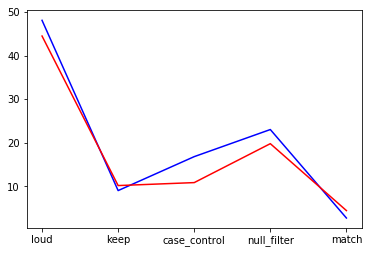

In [9]:
'''
plots all the different times to complete each step 
total time is not included in the plot since it makes the the resolution between other points in the plot
'''
index_to_symbol = {'ag_base':'b', 'ag_1':'r', 'ag_2':'y', 'emp_base':'g', 'emp_1':'c'
                  }

for index, row in plotDF.iterrows():
    plt.plot(('loud', 'keep', 'case_control', 'null_filter', 'match'), (row['load'], row['keep'], row['case_control'], 
       row['null_filter'], row['match']), index_to_symbol[index], label = index)
    
    #plt.plot('total', row['total'], index_to_symbol[index])

plt.legend()
plt.ylabel('Time (sec)')    
plt.xlabel('Stage')
plt.show()

dataframe = pd.read_csv('emp_qiime_mapping_release1.tsv', sep='\t')
dataframe
Metadata.load( 'emp_qiime_mapping_release1.tsv' ).to_dataframe()['qc_filtered']